# AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

**1. particle-resolved random-sampled state representation for an advection problem**

In [22]:
"""------------------------------------
Your code has been rated at 10.00/10
------------------------------------"""
from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot as plt
import scipy
from open_atmos_jupyter_utils import show_plot

In [23]:
PARAMS_P = SimpleNamespace(
    n_part=1000,
    norm=1e10,
    dist_x=scipy.stats.norm(loc=250, scale=50),
    dist_y=scipy.stats.norm(loc=250, scale=50),
)

PARAMS_X = SimpleNamespace(
    span_x=1000,
    span_y=1000,
    n_cell_x=50,
    n_cell_y=50,
)
PARAMS_X.step_x = PARAMS_X.span_x / PARAMS_X.n_cell_x
PARAMS_X.step_y = PARAMS_X.span_y / PARAMS_X.n_cell_y

RNG = np.random.default_rng(seed=420)

In [24]:
def sample_2d(*, params_p, params_x, rng):
    """Samples 2D particles with uniform random sampling and constant multiplicity."""
    u01_x = rng.uniform(0, 1, size=params_p.n_part)
    u01_y = rng.uniform(0, 1, size=params_p.n_part)

    x_rand = u01_x * params_x.span_x
    y_rand = u01_y * params_x.span_y

    return {
        k: {
            'cell_x': (v['x'] / params_x.step_x).astype(int),
            'cell_y': (v['y'] / params_x.step_y).astype(int),
            'mult': np.round(v['mult'] * params_p.norm).astype(int),
        }
        for k, v in {
            'sampling: uniform random in 2d': {
                'x': x_rand,
                'y': y_rand,
                'mult': (
                    params_p.dist_x.pdf(x_rand) *
                    params_p.dist_y.pdf(y_rand) *
                    params_x.span_x * params_x.span_y / params_p.n_part
                ),
            },
            'sampling: constant multiplicity 2d': {
                'x': params_p.dist_x.ppf(u01_x),
                'y': params_p.dist_y.ppf(u01_y),
                'mult': np.ones_like(u01_x) / params_p.n_part,
            },
        }.items()
    }

PARTICLES_2D = sample_2d(params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

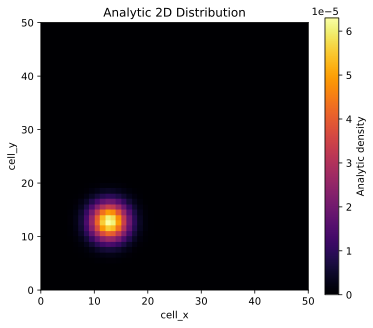

In [25]:
x = np.linspace(0, PARAMS_X.span_x, PARAMS_X.n_cell_x)
y = np.linspace(0, PARAMS_X.span_y, PARAMS_X.n_cell_y)
x, y = np.meshgrid(x, y, indexing='ij')

pdf_2d = PARAMS_P.dist_x.pdf(x) * PARAMS_P.dist_y.pdf(y)

def plot_analytic_pdf_2d(pdf, params_x):
    """Plots analytic 2D PDF."""
    plt.figure(figsize=(6, 5))
    plt.imshow(
        pdf.T, origin='lower',
        extent=[0, params_x.n_cell_x, 0, params_x.n_cell_y],
        aspect='equal',
        cmap='inferno'
    )
    plt.colorbar(label='Analytic density')
    plt.title('Analytic 2D Distribution')
    plt.xlabel('cell_x')
    plt.ylabel('cell_y')
    plt.grid(False)
    plt.show()

plot_analytic_pdf_2d(pdf_2d, params_x=PARAMS_X)

In [26]:
def compute_analytic_center_of_mass(pdf):
    """Computes center of mass (in cell units) from analytic 2D PDF."""
    n_x, n_y = pdf.shape
    x_param = np.arange(n_x)
    y_param = np.arange(n_y)
    a, b = np.meshgrid(x_param, y_param, indexing='ij')

    total_mass = np.sum(pdf)
    cx = np.sum(a * pdf) / total_mass
    cy = np.sum(b * pdf) / total_mass
    return cx, cy

In [27]:
def plot_2d(particles, params_p, params_x, rng,
analytic_center=None
):
    """Plots 2D particles with two histograms, scatter plot,
    center of mass, and analytic overlays."""

    fig, axs = plt.subplot_mosaic(
        [['hist1', 'hist2'],
         ['part',  'part']],
        figsize=(14, 10),
        tight_layout=True,
    )

    # Plot histograms
    for i, k in enumerate(list(particles.keys())[:2]):
        ax_hist = axs[f'hist{i+1}']

        h = ax_hist.hist2d(
            particles[k]['cell_x'], particles[k]['cell_y'],
            bins=[params_x.n_cell_x, params_x.n_cell_y],
            weights= particles[k]['mult'] / params_p.norm,
            range=[[0, params_x.n_cell_x], [0, params_x.n_cell_y]],
            cmap='viridis',
        )
        fig.colorbar(h[3], ax=ax_hist).set_label('Relative density (normalized multiplicity)')
        ax_hist.set_title(f'Histogram: {k}')
        ax_hist.set_xlabel('cell_x')
        ax_hist.set_ylabel('cell_y')
        ax_hist.grid(True)

    # Scatter plot + center overlays
    for k in list(particles.keys()):
        jitter_x = particles[k]['cell_x'] + rng.uniform(0, 1, size=params_p.n_part)
        jitter_y = particles[k]['cell_y'] + rng.uniform(0, 1, size=params_p.n_part)
        axs['part'].scatter(
            jitter_x,
            jitter_y,
            s=0.25 + 2 * particles[k]['mult'] / (params_p.norm / params_p.n_part),
            label=k,
            alpha=0.5
        )

    if analytic_center:
        cx, cy = analytic_center
        axs['part'].plot(
            cx, cy, 'P', markersize=14, color='gold',
            markeredgecolor='black', label='Analytic CoM'
        )
    axs['part'].set_title("2D Particle Sampling")
    axs['part'].set_xlabel('cell_x')
    axs['part'].set_ylabel('cell_y')
    axs['part'].set_xlim(0, params_x.n_cell_x)
    axs['part'].set_ylim(0, params_x.n_cell_y)
    axs['part'].legend()
    axs['part'].grid(True)

    show_plot()

analytic = compute_analytic_center_of_mass(pdf_2d)
plot_2d(particles=PARTICLES_2D,
        params_p=PARAMS_P,
        params_x=PARAMS_X,
        rng=RNG,
        analytic_center=analytic)

**2. Monte-Carlo representation of advection dynamics**

In [28]:
def compute_mc_analytic_center(params_p, params_t, params_x):
    """Computes the expected center of mass in grid coordinates after Monte Carlo advection."""
    mu_x = params_p.dist_x.mean()
    mu_y = params_p.dist_y.mean()

    t = params_t.n_step * params_t.step

    final_x = mu_x + params_t.wind_x * t
    final_y = mu_y + params_t.wind_y * t

    cx = final_x / params_x.step_x
    cy = final_y / params_x.step_y
    return cx, cy

In [29]:
PARAMS_T = SimpleNamespace(
    span=300,
    n_step=30,
    wind_x=1.0,
    wind_y=1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_x = PARAMS_T.wind_x / PARAMS_X.step_x * PARAMS_T.step
PARAMS_T.courant_y = PARAMS_T.wind_y / PARAMS_X.step_y * PARAMS_T.step

In [30]:
def advect_2d(*, params_p, params_t, particles, rng):
    """Performs Monte Carlo advection of particles in 2D grid."""
    prob_x = abs(params_t.courant_x)
    prob_y = abs(params_t.courant_y)
    sign_x = int(np.sign(params_t.courant_x))
    sign_y = int(np.sign(params_t.courant_y))

    assert prob_x < 1 and prob_y < 1, "Courant condition violated!"

    for _ in range(params_t.n_step):
        u_x = rng.uniform(0, 1, params_p.n_part)
        u_y = rng.uniform(0, 1, params_p.n_part)

        for k in particles:
            particles[k]['cell_x'] += (u_x < prob_x) * sign_x
            particles[k]['cell_y'] += (u_y < prob_y) * sign_y

In [31]:
advect_2d(particles=PARTICLES_2D, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)
analytic_mc = compute_mc_analytic_center(
    params_p=PARAMS_P,
    params_t=PARAMS_T,
    params_x=PARAMS_X
)
plot_2d(
    particles=PARTICLES_2D,
    params_p=PARAMS_P,
    params_x=PARAMS_X,
    rng=RNG,
    analytic_center=analytic_mc
)